# 세미3 프로젝트 

### Subject - Loan Prediction Based on Customer Behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 연속적 print, output clear
## source : display(target), clear_output(wait=True)
from IPython.display import clear_output

#Console Prograss Bar
from tqdm import tqdm, trange, tqdm_notebook

from sklearn import preprocessing, model_selection
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

import os
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.pipeline import Pipeline

#from imblearn.combine import SMOTETomek,SMOTEENN

## 01. Function
1.1 BI Chart Draw

In [2]:
def fn_auc(p_fpr, p_tpr):
    plt.style.use('fivethirtyeight') 
    fig, ax = plt.subplots() 
    fig.set_size_inches(4.8, 5) 
    ax.step(fpr, tpr, 'gray') 
    ax.fill_between(p_fpr, p_tpr, 0, color='skyblue', alpha=0.8) 
    ax.set_xlabel('False Positive Rate') 
    ax.set_ylabel('True Positive Rate') 
    ax.set_facecolor('xkcd:white') 
    plt.show()
    
#특성 중요도 수평 막대그래프
def fn_feature_horizontal_graph(p_model, p_np_data, p_df_x_train, p_numeric_features, p_cat_features):
    trans_features = []
    
    trans_features = p_numeric_features
    
    for f_col in p_cat_features:
        for i in range(p_df_x_train.groupby(f_col)[f_col].count().groupby(f_col).count().sum()):
            trans_features.append(f_col + '_' + str(i))
    
    plt.figure(figsize=(20,40))
    n_features = p_np_data.data.shape[1]
    plt.barh(range(n_features), p_model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features),trans_features)
    plt.xlabel("Features Importances")
    plt.ylabel("Features")
    plt.ylim(-1,n_features)
    plt.show()

## 02. 전처리 Proc

2.1 Data Load

In [3]:
x_train = pd.read_csv("x_train.csv")
x_test = pd.read_csv("x_test.csv")

2.2 Proc PipLIne(OneHotEncoder, StandardScaler)

In [4]:
x_train_target = x_train[['Risk_Flag']].copy()
x_train_data = x_train.copy()

x_test_target = x_test[['Risk_Flag']].copy()
x_test_data = x_test.copy()

del x_train_data['Risk_Flag']
del x_test_data['Risk_Flag']

In [5]:
x_train_data

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,changed_profession
0,3643187,77,20,1,2,0,50,11,12,14,1
1,6467283,65,13,1,2,1,2,13,11,12,1
2,2307941,32,18,1,0,0,17,28,13,10,1
3,7681002,25,4,1,2,0,14,14,4,13,0
4,3921208,43,20,1,2,1,23,2,11,12,1
...,...,...,...,...,...,...,...,...,...,...,...
99415,9215066,69,11,1,2,0,32,2,11,10,0
99416,2541624,32,15,1,2,0,28,25,3,12,1
99417,7334328,60,12,1,2,0,20,22,9,11,1
99418,960205,66,16,1,2,0,12,0,7,11,1


In [6]:
# Pipline
numeric_features = ['Income','Age','Experience',
                    'CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']
numeric_transformer = preprocessing.StandardScaler()

categorical_features = ['Married/Single','House_Ownership',
                        'Car_Ownership','changed_profession',
                        'Profession','STATE']
categorical_transformer = preprocessing.OneHotEncoder(sparse=False)

preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

# x_train과 x_test 전처리 작업을 위한 fit (SC, One-Hot Encoder 적용 중)
preprocessor_pipe.fit(x_train_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Income', 'Age',
                                                   'Experience',
                                                   'CURRENT_JOB_YRS',
                                                   'CURRENT_HOUSE_YRS']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['Married/Single',
                                                   'House_Ownership',
                                                   'Car_Ownership',
                                                   'changed_profession',
                                                   'Profession', 'STATE'])]))])

In [7]:
x_train_transformed = preprocessor_pipe.transform(x_train_data)
x_test_transformed = preprocessor_pipe.transform(x_test_data)

x_train_tns = pd.DataFrame(x_train_transformed)
x_test_tns = pd.DataFrame(x_test_transformed)

In [8]:
x_train_tns.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,-0.461576,1.609132,1.708327,1.578942,1.463509,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.511193,0.904605,0.537845,1.305573,0.022052,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.921506,-1.032846,1.373904,1.852312,-1.419404,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.929263,-1.443820,-0.967059,-0.608015,0.742781,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.365811,-0.387029,1.708327,1.305573,0.022052,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 03. Traditional ML

In [9]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

3.1 ExtraTreesClassifier

In [10]:
x_train_transformed.shape

(99420, 94)

In [11]:
xtree = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [12]:
# x_train_target = x_train[['Risk_Flag']].copy()
# x_train_data = x_train.copy()

# x_test_target = x_test[['Risk_Flag']].copy()
# x_test_data = x_test.copy()

In [13]:
xtree.fit(x_train_transformed, x_train_target)

<ipython-input-13-a513561e4162>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtree.fit(x_train_transformed, x_train_target)


ExtraTreesClassifier(n_jobs=-1, random_state=123)

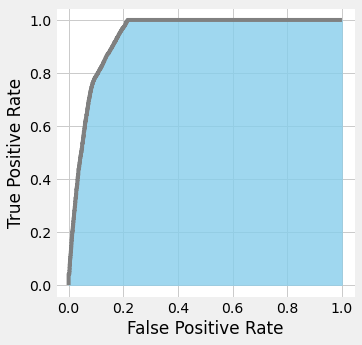

In [14]:
probas = xtree.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(x_test_target, probas[:,1])
fn_auc(fpr, tpr)

In [15]:
score = roc_auc_score(x_test_target, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', xtree.score(x_test_transformed, x_test_target))

AUC score 	: 0.9371534291315124
Model Score 	: 0.8638492063492064


ValueError: The number of FixedLocator locations (94), usually from a call to set_ticks, does not match the number of ticklabels (183).

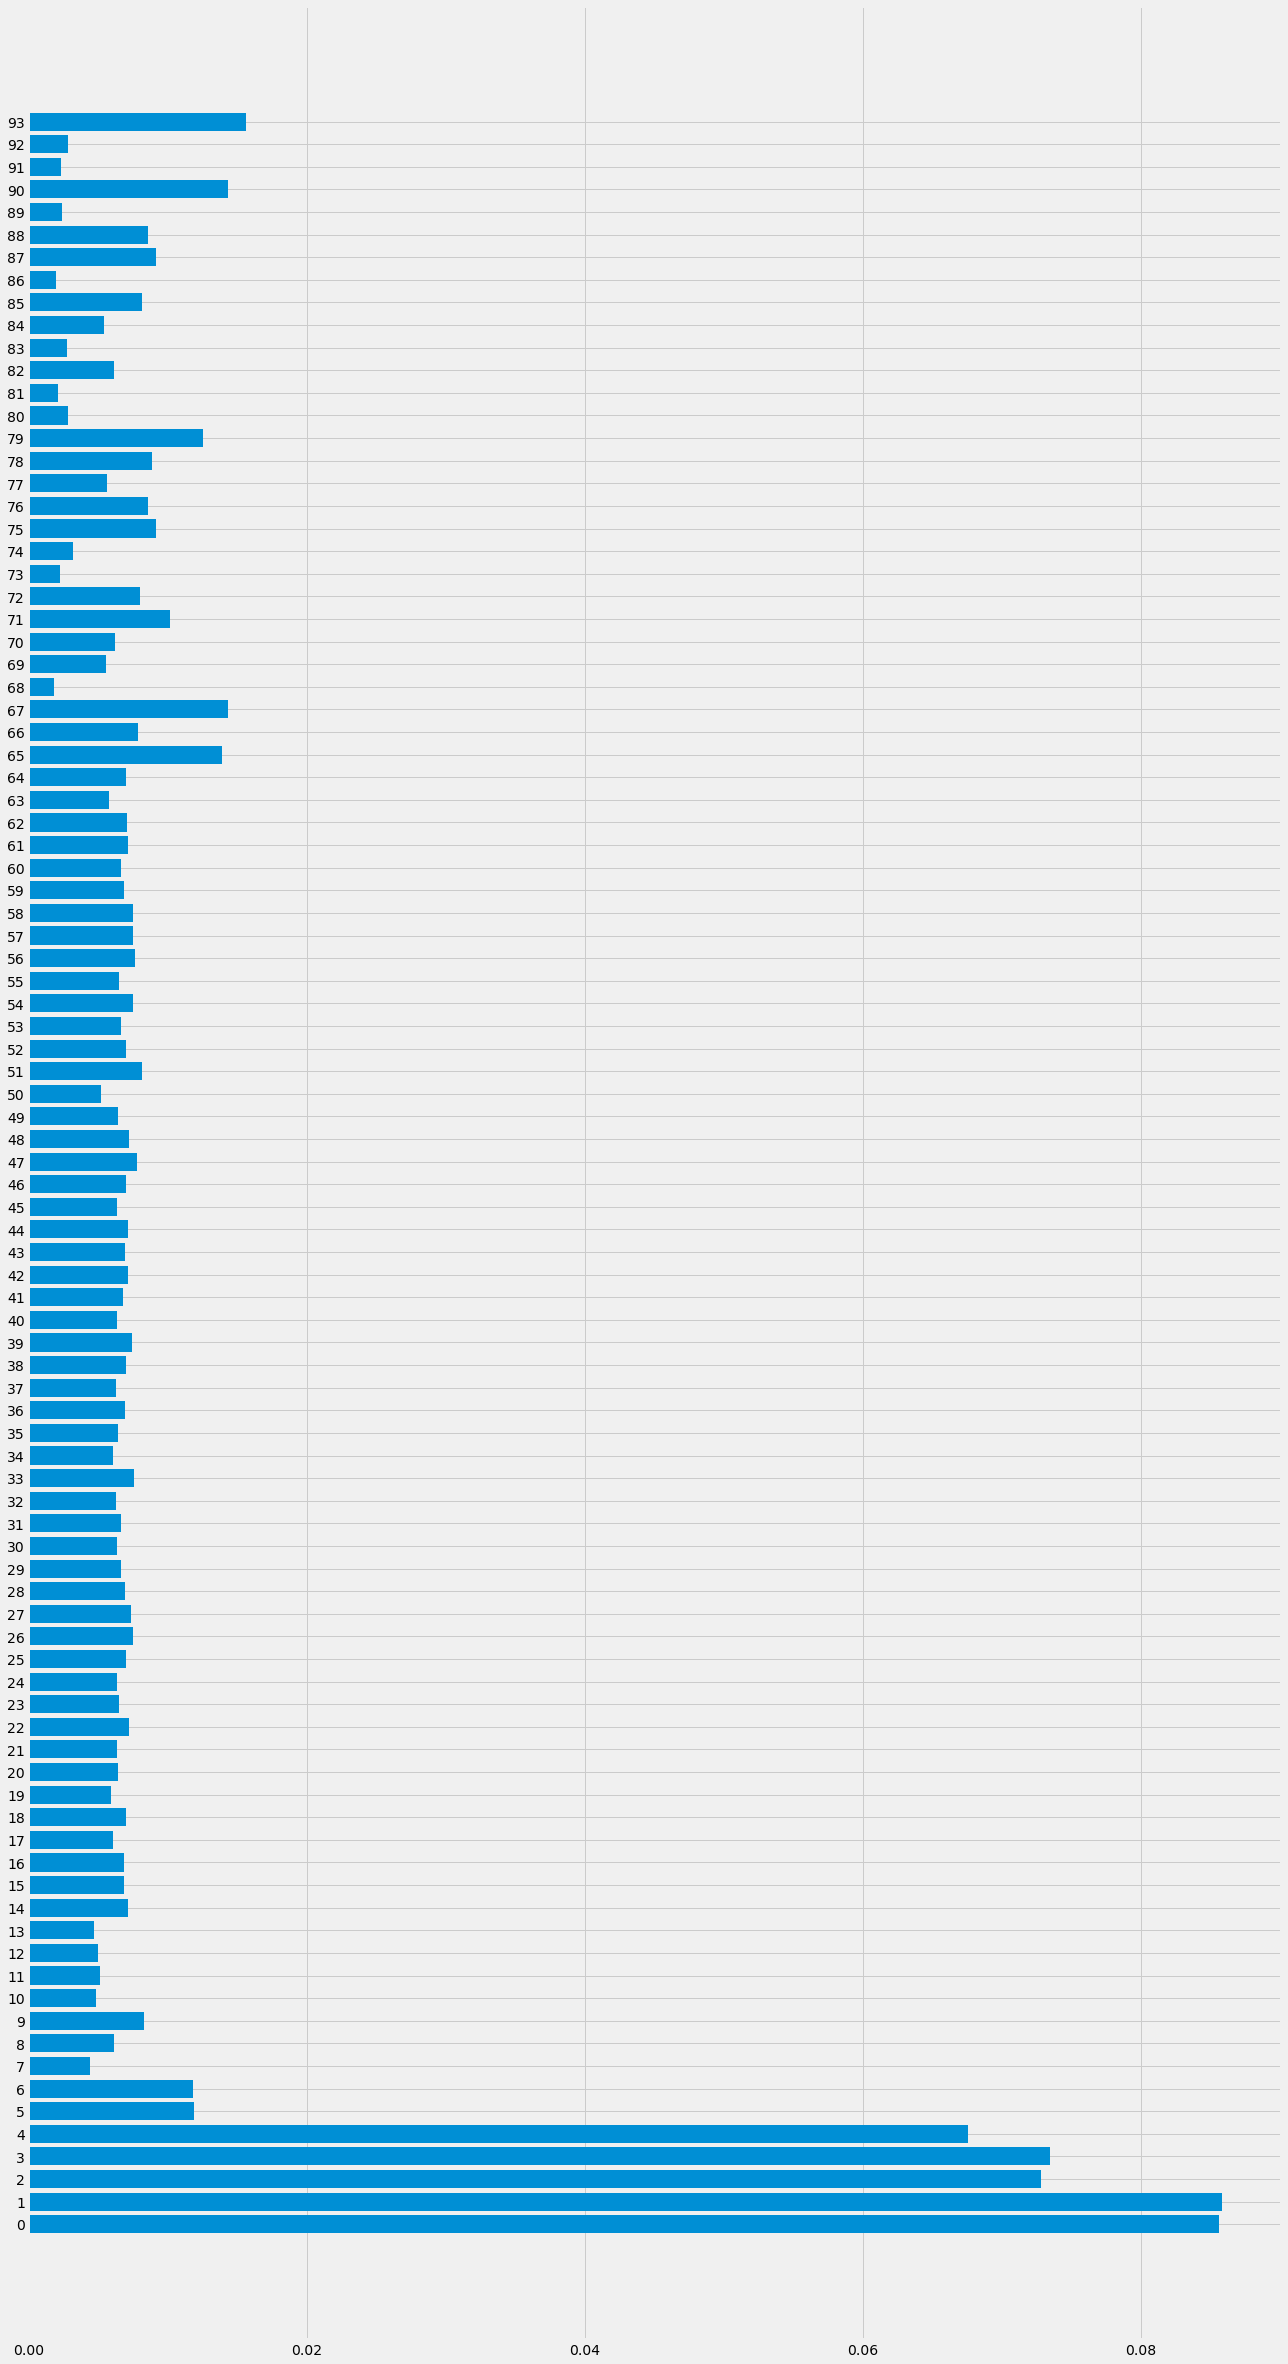

In [17]:
fn_feature_horizontal_graph(xtree, x_train_transformed, x_train_data, numeric_features, categorical_features)

3.2 DecisionTreeClassifier

In [26]:
dtree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=123, splitter='best')

In [27]:
dtree.fit(x_train_transformed, x_train_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

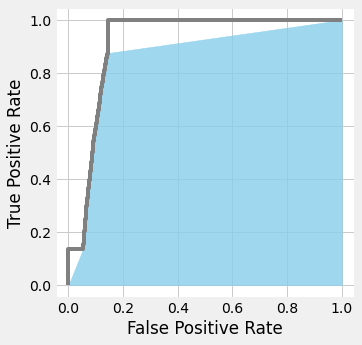

In [28]:
probas = dtree.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(x_test_target, probas[:,1])
fn_auc(fpr, tpr)

In [29]:
score = roc_auc_score(x_test_target, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', dtree.score(x_test_transformed, x_test_target))

AUC score 	: 0.8569327569846985
Model Score 	: 0.8584920634920635


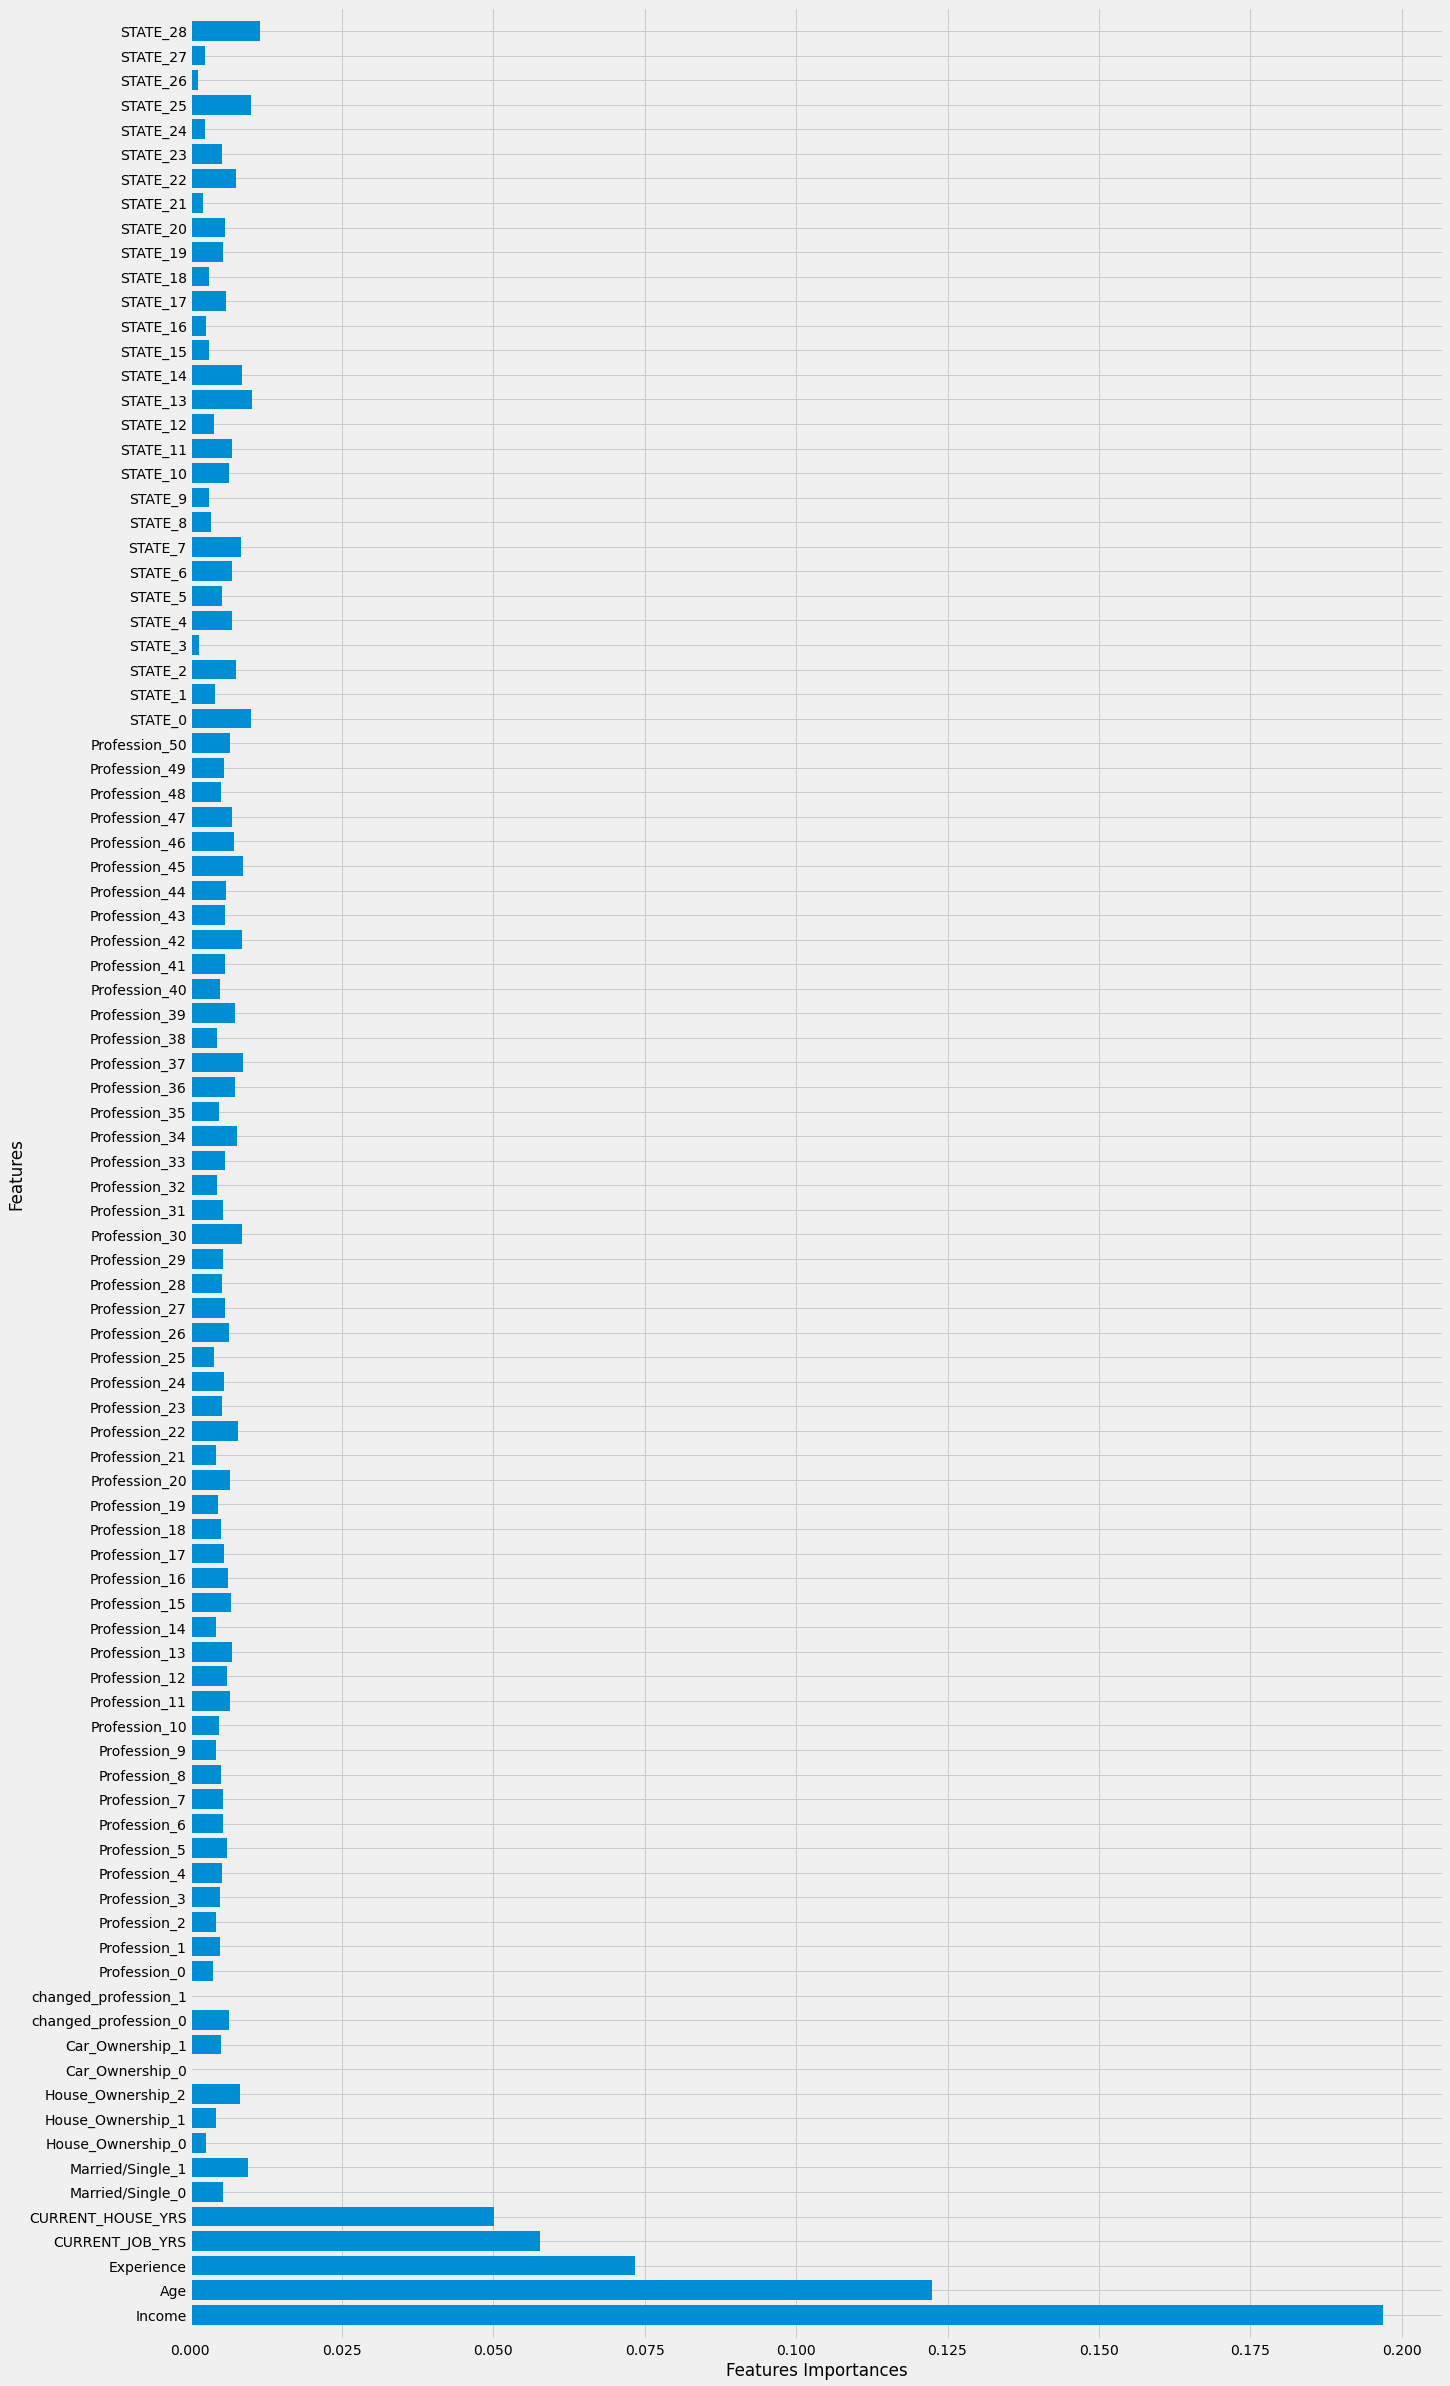

In [30]:
fn_feature_horizontal_graph(dtree, x_train_transformed, x_train_data, numeric_features, categorical_features)

3.3 RandomForestClassifier

In [20]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                        oob_score=False, random_state=123, verbose=0,
                        warm_start=False)

In [21]:
rf.fit(x_train_transformed, x_train_target)

<ipython-input-21-5793d33db1b3>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_transformed, x_train_target)


RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=123)

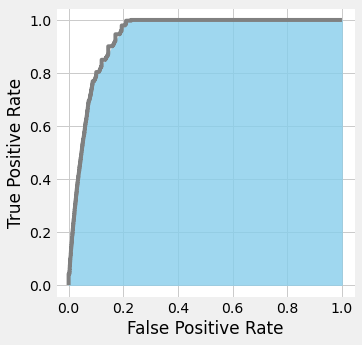

In [22]:
probas = rf.predict_proba(x_test_transformed) 
fpr, tpr, thresholds = roc_curve(x_test_target, probas[:,1])
fn_auc(fpr, tpr)

In [23]:
score = roc_auc_score(x_test_target, probas[:,1])
print('AUC score \t:' , score)
print('Model Score \t:', rf.score(x_test_transformed, x_test_target))

AUC score 	: 0.9355662742411668
Model Score 	: 0.8727777777777778


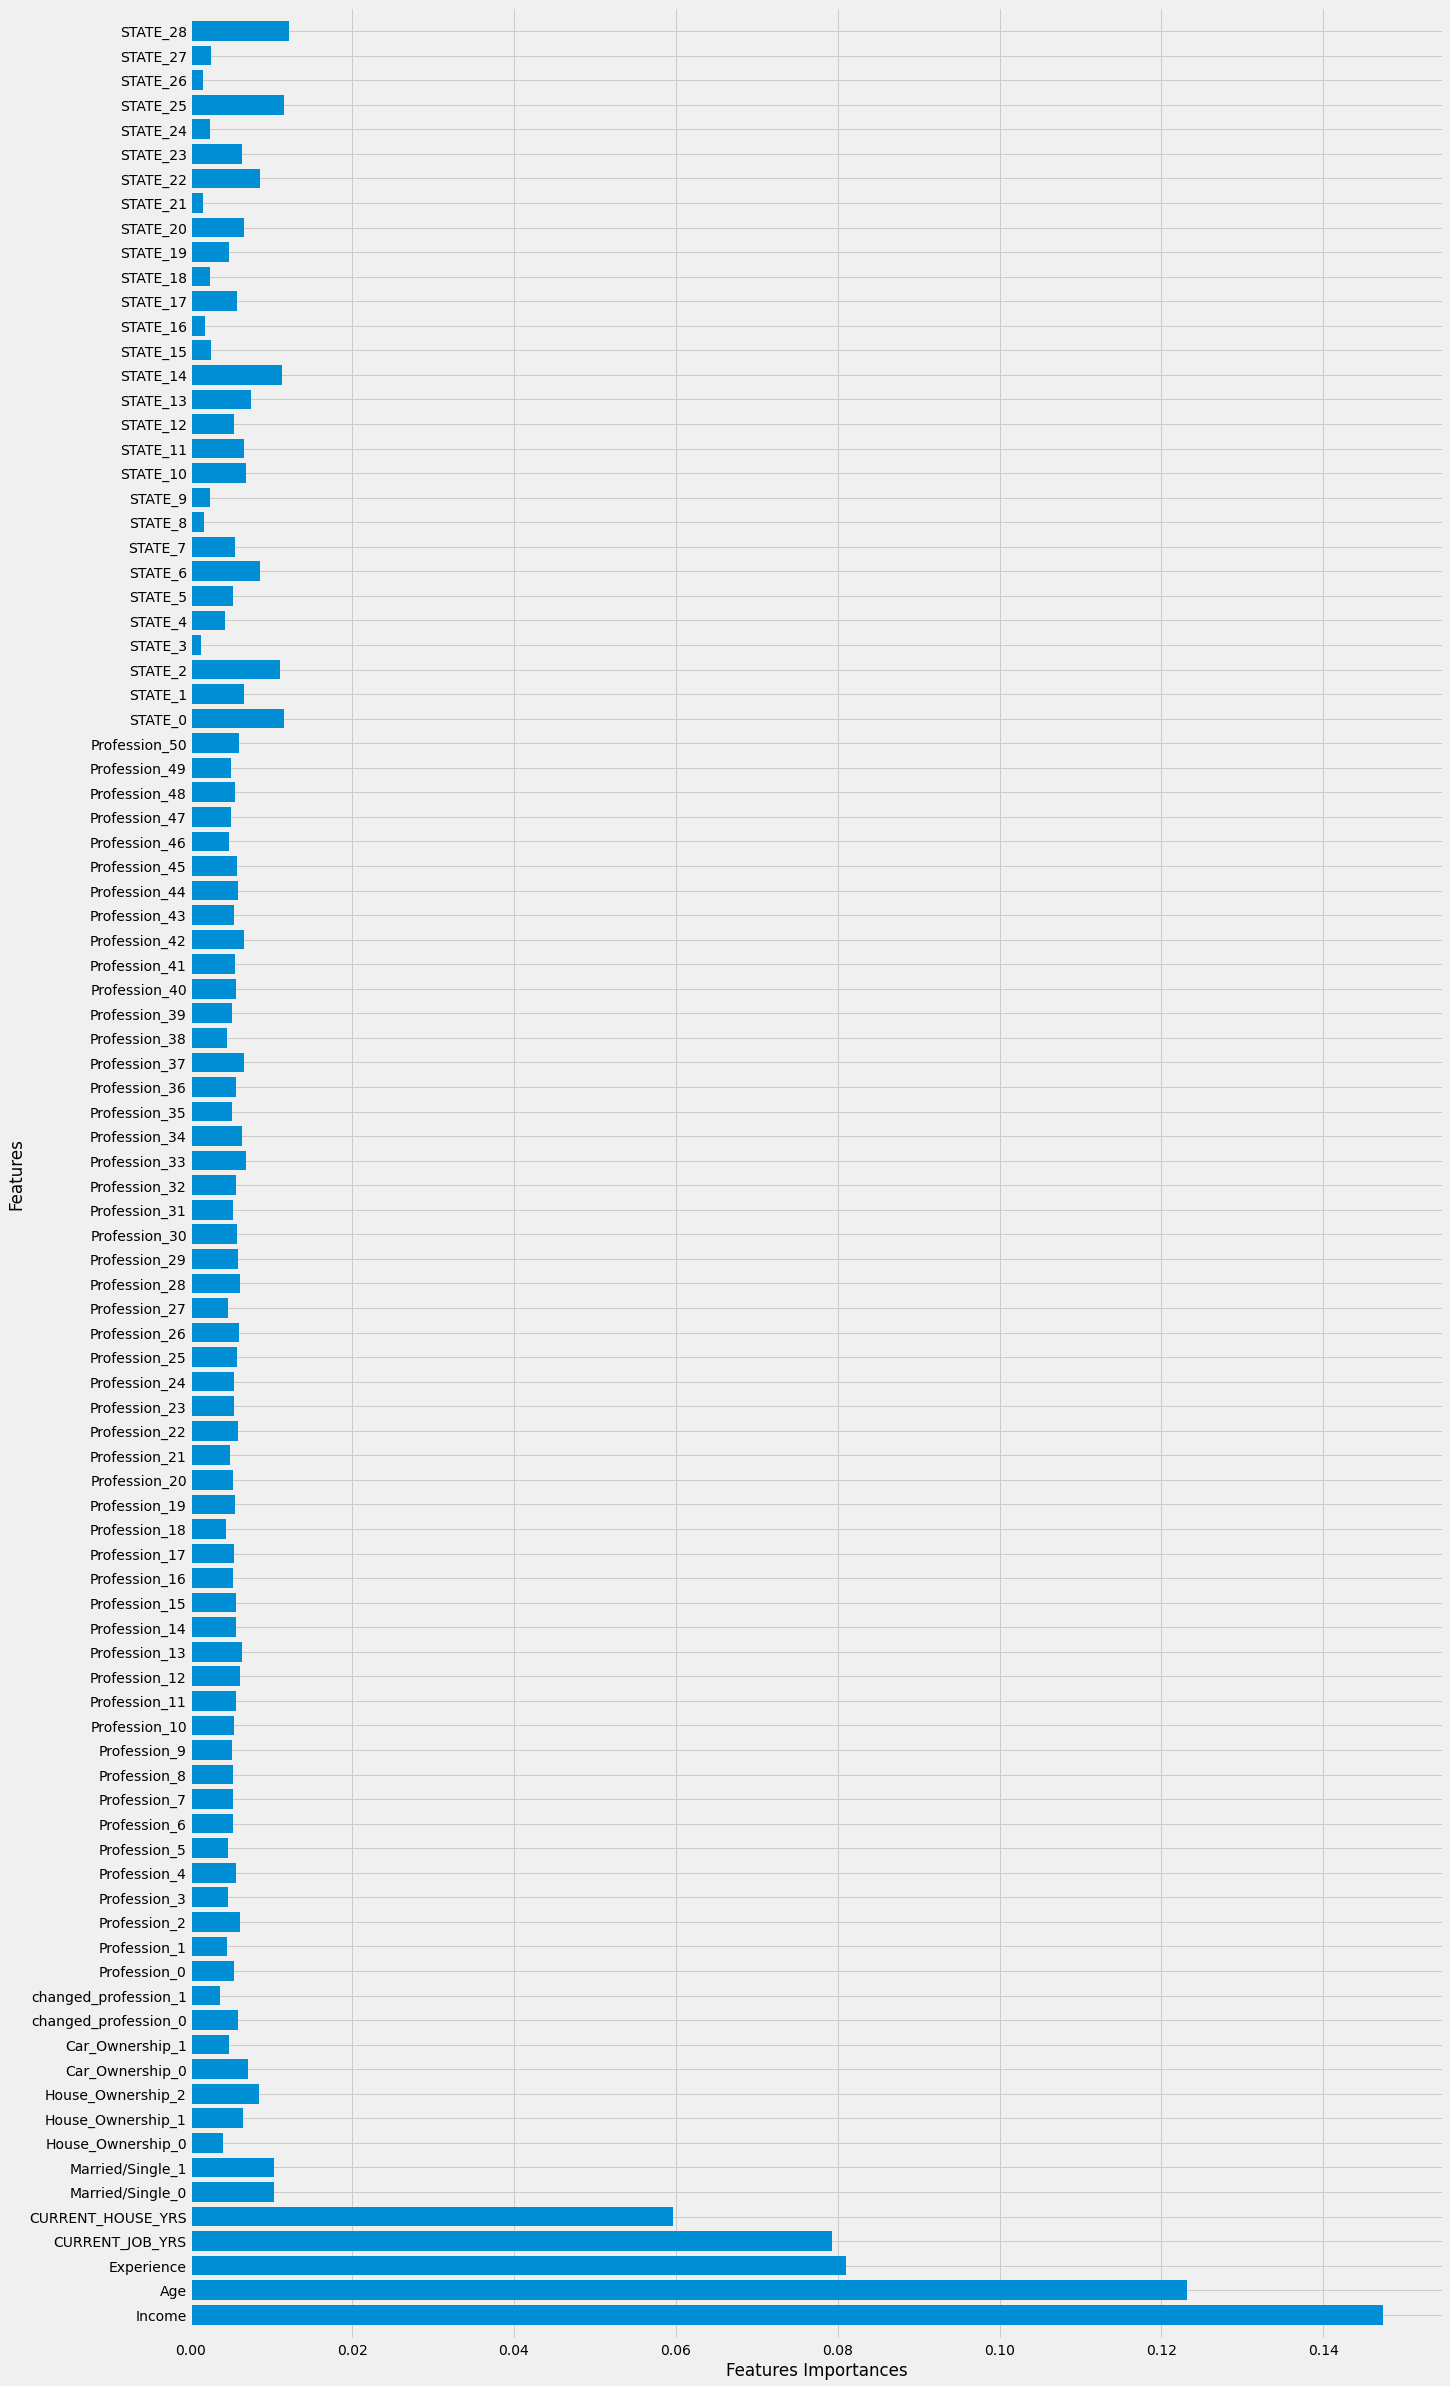

In [35]:
fn_feature_horizontal_graph(rf, x_train_transformed, x_train_data, numeric_features, categorical_features)

# 04. 딥러닝

In [76]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# import kerastuner as kt   
from tensorflow import keras 

from tensorflow.keras import datasets, utils
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization 

import IPython

In [ ]:
# x_train_target = x_train[['Risk_Flag']].copy()
# x_train_data = x_train.copy()

# x_test_target = x_test[['Risk_Flag']].copy()
# x_test_data = x_test.copy()

In [77]:
from sklearn import preprocessing

# Apply 'One-hot encoding' on labels (Single integer to One-hot vector)
enc = preprocessing.OneHotEncoder(categories='auto')

train_label = enc.fit_transform(x_train_target).toarray()
test_label = enc.fit_transform(x_test_target).toarray()

print(train_label.shape) # 모양을 영어로?
print(test_label.shape) # 모양을 영어로?

(99420, 2)
(50400, 2)


In [85]:
model = models.Sequential()


#신경망 만들기
# model.add(layers.BatchNormalization()) # Use this line as if needed #오퍼피팅심하다싶으면 배치로
model.add(layers.Dense(input_dim=94, units=512, activation=None, kernel_initializer=initializers.he_uniform()))
model.add(layers.Activation('relu'))

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('relu')) 

model.add(layers.Dense(units=384, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.1)) 
 

model.add(layers.Dense(units=2, activation='softmax')) # Apply softmax function on model's output

In [86]:
#묶어주는것 
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),  
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) 

In [47]:
# x_train_transformed = preprocessor_pipe.transform(x_train_data)
# x_test_transformed = preprocessor_pipe.transform(x_test_data)

# x_train_tns = pd.DataFrame(x_train_transformed)
# x_test_tns = pd.DataFrame(x_test_transformed)

(99420, 11)

In [87]:
history = model.fit(x_train_transformed, train_label, batch_size=100, epochs=15, validation_split=0.1)

Epoch 1/15
895/895 [==============================] - 5s 5ms/step - loss: 0.6455 - categorical_accuracy: 0.6227 - val_loss: 0.7577 - val_categorical_accuracy: 0.4737
Epoch 2/15
895/895 [==============================] - 4s 4ms/step - loss: 0.5223 - categorical_accuracy: 0.7595 - val_loss: 0.6043 - val_categorical_accuracy: 0.7058
Epoch 3/15
895/895 [==============================] - 4s 5ms/step - loss: 0.4270 - categorical_accuracy: 0.8324 - val_loss: 0.4461 - val_categorical_accuracy: 0.8444
Epoch 4/15
895/895 [==============================] - 4s 5ms/step - loss: 0.3805 - categorical_accuracy: 0.8587 - val_loss: 0.2599 - val_categorical_accuracy: 0.9206
Epoch 5/15
895/895 [==============================] - 4s 5ms/step - loss: 0.3548 - categorical_accuracy: 0.8712 - val_loss: 0.2893 - val_categorical_accuracy: 0.9112
Epoch 6/15
895/895 [==============================] - 4s 4ms/step - loss: 0.3381 - categorical_accuracy: 0.8768 - val_loss: 0.1973 - val_categorical_accuracy: 0.9370
Epoc

In [88]:
# "Evaluate" the model on test data

result = model.evaluate(x_test_transformed, test_label) 
#모델 평가하는것(x,y)x데이터를 예측하고  y데이터를 만나게끔 함

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

1575/1575 [==============================] - 5s 3ms/step - loss: 0.3365 - categorical_accuracy: 0.8717
loss (cross-entropy) : 0.33652952313423157
test accuracy : 0.871666669845581


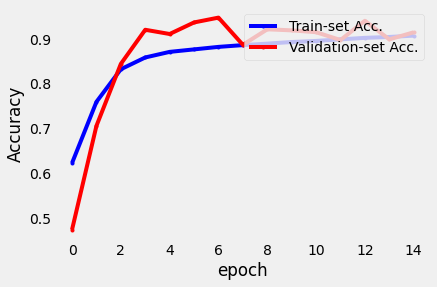

In [89]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc)) 

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

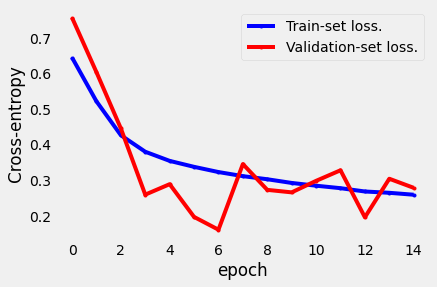

In [90]:
#graph(loss)
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

# 케라스 튜너로 최적값 찾기

In [60]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 3.6 MB/s 


In [61]:
import tensorflow as tf
import kerastuner as kt

print(tf.__version__)
print(kt.__version__)

2.6.0
1.0.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [62]:
from tensorflow import keras 
from tensorflow.keras import layers

In [63]:
from sklearn import model_selection
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization

In [64]:
from sklearn.metrics import accuracy_score

In [65]:
def build_hyper_model(hp):
    
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(94,))) #초기에 밀어넣는 열 넣어주면 됨 
        
    # Tune the number of hidden layer (Choose an optimal value between 1~3)
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)): 
        # Tune the number of perceptrons in a dense layer (Choose an optimal value between 32~512) 
        hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32) # 32:512 & step 32, all parameter names should be unique (we name the inner parameters 'units_' + str(i))
        hp_activations = hp.Choice('activation_' + str(i), values=['relu', 'elu'])
        model.add(layers.Dense(units = hp_units, activation = hp_activations))

    model.add(layers.Dense(2, activation='softmax')) # class 10 : 0~9

    # Tune the learning rate for the optimizer (Choose an optimal value from 0.01, 0.001, or 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.CategoricalCrossentropy(),
                metrics = ['categorical_accuracy'])
    
    return model

In [66]:
tuner = kt.BayesianOptimization(build_hyper_model,
                                objective = 'val_categorical_accuracy', # Hyper-params tuning을 위한 목적함수 설정 (metric to minimize or maximize)
                                max_trials = 10, # 서로 다른 Hyper-params 조합으로 시도할 총 Trial 횟수 설정
                                directory = 'test_prac_dir', # Path to the working directory
                                project_name = 'loan_default') # Name to use as directory name for files saved by this Tuner

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [68]:
# 4) Train the model

tuner.search(x_train_transformed, train_label, epochs=10, validation_data = (x_test_transformed, test_label)) 
# epochs == learning epoch for training a single model(epoch for each trial) 

Trial 10 Complete [00h 02m 49s]
val_categorical_accuracy: 0.8829761743545532

Best val_categorical_accuracy So Far: 0.8829761743545532
Total elapsed time: 00h 31m 35s


In [69]:
tuner.results_summary(num_trials=3)

Results summary
Results in test_prac_dir/loan_default
Showing 3 best trials
Objective(name='val_categorical_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
activation_0: relu
learning_rate: 0.0001
units_1: 512
activation_1: relu
units_2: 384
activation_2: elu
Score: 0.8829761743545532
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
activation_0: relu
learning_rate: 0.0001
units_1: 256
activation_1: relu
units_2: 32
activation_2: elu
Score: 0.8814682364463806
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
activation_0: relu
learning_rate: 0.0001
units_1: 32
activation_1: relu
units_2: 32
activation_2: relu
Score: 0.8738690614700317


In [24]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

probas = rf.predict(x_test_transformed)

print("accuracy_score: " + str(accuracy_score(x_test_target, probas)))
print("precision_score: " + str(precision_score(x_test_target, probas)))
print("recall_score: " + str(recall_score(x_test_target, probas)))
print("f1_score: " + str(f1_score(x_test_target, probas)))

accuracy_score: 0.8727777777777778
precision_score: 0.48700738325822224
recall_score: 0.8270639960918417
f1_score: 0.6130356065178032
